In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import r2_score, make_scorer
import sklearn.metrics as metrics
from sklearn.pipeline import Pipeline

### Import dataset

In [2]:
url='https://raw.githubusercontent.com/jenfly/opsd/master/opsd_germany_daily.csv'
data = pd.read_csv(url,sep=",")
display(data)

,Date,Consumption,Wind,Solar,Wind+Solar
0,2006-01-01,1069.18400,NaN,NaN,NaN
1,2006-01-02,1380.52100,NaN,NaN,NaN
2,2006-01-03,1442.53300,NaN,NaN,NaN
3,2006-01-04,1457.21700,NaN,NaN,NaN
4,2006-01-05,1477.13100,NaN,NaN,NaN
...,...,...,...,...,...
4378,2017-12-27,1263.94091,394.507,16.530,411.037
4379,2017-12-28,1299.86398,506.424,14.162,520.586
4380,2017-12-29,1295.08753,584.277,29.854,614.131
4381,2017-12-30,1215.44897,721.247,7.467,728.714


In [3]:
data.dtypes

Date            object
Consumption    float64
Wind           float64
Solar          float64
Wind+Solar     float64
dtype: object

In [4]:
print(data['Date'][0],  type(data['Date'][0]))

2006-01-01 <class 'str'>


In [5]:
# converting data to correct format 
data['Date'] = pd.to_datetime(data['Date'])
display(data)
# check data types of columns
print(data.dtypes)

,Date,Consumption,Wind,Solar,Wind+Solar
0,2006-01-01,1069.18400,NaN,NaN,NaN
1,2006-01-02,1380.52100,NaN,NaN,NaN
2,2006-01-03,1442.53300,NaN,NaN,NaN
3,2006-01-04,1457.21700,NaN,NaN,NaN
4,2006-01-05,1477.13100,NaN,NaN,NaN
...,...,...,...,...,...
4378,2017-12-27,1263.94091,394.507,16.530,411.037
4379,2017-12-28,1299.86398,506.424,14.162,520.586
4380,2017-12-29,1295.08753,584.277,29.854,614.131
4381,2017-12-30,1215.44897,721.247,7.467,728.714


Date           datetime64[ns]
Consumption           float64
Wind                  float64
Solar                 float64
Wind+Solar            float64
dtype: object


In [6]:
# set 'date' as the index of dataframe 
data = data.set_index('Date')
display(data)

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2006-01-01,1069.18400,NaN,NaN,NaN
2006-01-02,1380.52100,NaN,NaN,NaN
2006-01-03,1442.53300,NaN,NaN,NaN
2006-01-04,1457.21700,NaN,NaN,NaN
2006-01-05,1477.13100,NaN,NaN,NaN
...,...,...,...,...
2017-12-27,1263.94091,394.507,16.530,411.037
2017-12-28,1299.86398,506.424,14.162,520.586
2017-12-29,1295.08753,584.277,29.854,614.131


In [7]:
data.columns

Index(['Consumption', 'Wind', 'Solar', 'Wind+Solar'], dtype='object')

### Cleaning dataset

In [8]:
data.isna().sum()

Consumption       0
Wind           1463
Solar          2195
Wind+Solar     2196
dtype: int64

In [9]:
df = data.dropna()
display(df)

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2012-01-01,948.12800,227.465,6.587,234.052
2012-01-02,1269.58100,207.327,6.574,213.901
2012-01-03,1334.74500,473.468,24.679,498.147
2012-01-04,1347.13600,499.804,14.681,514.485
2012-01-05,1376.65800,523.851,5.071,528.922
...,...,...,...,...
2017-12-27,1263.94091,394.507,16.530,411.037
2017-12-28,1299.86398,506.424,14.162,520.586
2017-12-29,1295.08753,584.277,29.854,614.131


### Visualizing time series data

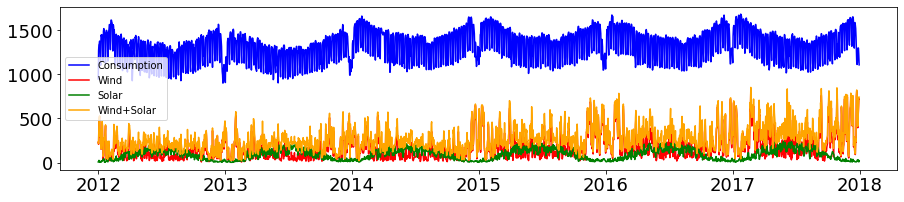

In [10]:
plt.rcParams.update({'font.size': 18}) # must set in top

plt.figure(figsize=(15,3))
plt.plot(df.Consumption, 'b', label='Consumption')
plt.plot(df.Wind, 'r', label='Wind')
plt.plot(df.Solar, 'g', label='Solar')
plt.plot(df['Wind+Solar'], 'orange', label='Wind+Solar')

plt.legend(loc='best', fontsize=10)
plt.show()

In [11]:
data_consumption = data.loc[:,['Consumption']]

data_consumption['Yesterday'] = data_consumption.loc[:,['Consumption']].shift()
data_consumption.loc[:,'Yesterday'] = data_consumption.loc[:,['Consumption']].shift()
data_consumption.loc[:,'Yesterday_Diff'] = data_consumption.loc[:,['Yesterday']].diff()

data_consumption = data_consumption.dropna()

data_consumption

,Consumption,Yesterday,Yesterday_Diff
Date,,,
2006-01-03,1442.53300,1380.52100,311.33700
2006-01-04,1457.21700,1442.53300,62.01200
2006-01-05,1477.13100,1457.21700,14.68400
2006-01-06,1403.42700,1477.13100,19.91400
2006-01-07,1300.28700,1403.42700,-73.70400
...,...,...,...
2017-12-27,1263.94091,1130.11683,18.83345
2017-12-28,1299.86398,1263.94091,133.82408
2017-12-29,1295.08753,1299.86398,35.92307


### Set train and test dataset by splitting data_consumption

In [12]:
X_train = data_consumption[:'2016'].drop(['Consumption'], axis=1)
y_train = data_consumption.loc[:'2016', 'Consumption']

X_test = data_consumption['2017'].drop(['Consumption'], axis=1)
y_test = data_consumption.loc['2017', 'Consumption']
print(X_train)
print(y_train)

            Yesterday  Yesterday_Diff
Date                                 
2006-01-03   1380.521         311.337
2006-01-04   1442.533          62.012
2006-01-05   1457.217          14.684
2006-01-06   1477.131          19.914
2006-01-07   1403.427         -73.704
...               ...             ...
2016-12-27   1121.213           3.540
2016-12-28   1289.324         168.111
2016-12-29   1294.881           5.557
2016-12-30   1295.897           1.016
2016-12-31   1291.044          -4.853

[4016 rows x 2 columns]
Date
2006-01-03    1442.533
2006-01-04    1457.217
2006-01-05    1477.131
2006-01-06    1403.427
2006-01-07    1300.287
                ...   
2016-12-27    1289.324
2016-12-28    1294.881
2016-12-29    1295.897
2016-12-30    1291.044
2016-12-31    1212.568
Name: Consumption, Length: 4016, dtype: float64


### Helper function: performance metrics

In [13]:
def regression_results(y_true, y_pred):
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=r2_score(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))             
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

### Finding optimal forecasting model using GridSearchCV 

In [14]:
def rmse(actual, predict):
    predict = np.array(predict)
    actual = np.array(actual)
    distance = predict - actual
    square_distance = distance ** 2
    mean_square_distance = square_distance.mean()
    score = np.sqrt(mean_square_distance)
    return score

rmse_score = make_scorer(rmse, greater_is_better = False)

In [15]:
# Spot Check Algorithms
models = []
models.append(('LR', LinearRegression(), {
    'fit_intercept': [True, False]
}))
models.append(('KNN', KNeighborsRegressor(), { 
    'n_neighbors':[1,3,5], 
    'metric':['minkowski','manhattan','euclidean'], 
    'weights':['uniform','distance']
})) 
models.append(('RF', RandomForestRegressor(), { 
    'n_estimators': [3, 10,30, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,15)]
})) 
# Ensemble method - collection of many decision trees
models.append(('SVR', SVR(gamma='auto'), { 
    'C': [1, 100, 10, 0.1, 0.01, 0.001]
})) # kernel = linear

In [31]:
%%time

tscv = TimeSeriesSplit(n_splits=10)
results_estimator = {}
results_score = {}
for name, model, param in models:
    print(name)
    gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param, scoring=rmse_score)
    gsearch.fit(X_train, y_train)
    results_estimator[name]= gsearch.best_estimator_
    results_score[name]= gsearch.best_score_

LR
KNN
RF
SVR
Wall time: 2min 24s


In [35]:
best_model_name = max(results_score,key=results_score.get)
best_model = results_estimator[best_model_name]

### Save Model

In [46]:
import pickle
from datetime import datetime

filename = best_model_name + '_'+ datetime.now().strftime("%Y%m%d_%H%M%S") + '.pkl'
pickle.dump(best_model, open(filename,'wb'))

### Import Model & Predict

In [49]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

y_true = y_test.values
y_pred = loaded_model.predict(X_test)
regression_results(y_true, y_pred)

0.7300919886447702
explained_variance:  0.7325
mean_squared_log_error:  0.0041
r2:  0.7301
MAE:  55.0728
MSE:  7309.2398
RMSE:  85.4941
